<a href="https://colab.research.google.com/github/khiempm209/Deakin-SIT742-Ass2/blob/main/SIT742_Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set up

In [1]:
#update local version of the package catalog
!apt-get update
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark 3.3.3
!wget -q https://archive.apache.org/dist/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
# unzip it
!tar xf spark-3.3.3-bin-hadoop3.tgz
# install findspark
!pip install -q findspark

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

import findspark
findspark.init()

In [3]:
from google.colab import userdata
try:
  #load all the information about the github repository of team
  GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
  REPO_OWNER = userdata.get('REPO_OWNER')
  REPO_NAME = userdata.get('REPO_NAME')
  BRANCH = userdata.get('BRANCH')
except:
  print("This section is used to retrieve personal information from the Secrets section and needs to be installed in Google Colab")
  GITHUB_TOKEN = 'Your-Github-token'
  REPO_OWNER = 'Your-Username'
  REPO_NAME = 'Your-Repo'
  BRANCH = 'Your-Branch'

In [4]:
#create the function to push file to github
def put_file_to_github(FILE_PATH, UPLOAD_PATH):
    with open(FILE_PATH, "rb") as file:
         content = base64.b64encode(file.read()).decode()
    headers = {
        "Authorization": f"token {GITHUB_TOKEN}",
        "Accept": "application/vnd.github.v3+json"
    }
    data = {
        "message": "Add new file via Colab",
        "content": content,
        "branch": BRANCH
    }
    url = f"https://api.github.com/repos/{REPO_OWNER}/{REPO_NAME}/contents/{UPLOAD_PATH}"
    response = requests.put(url, json=data, headers=headers)
    if response.status_code == 201:
        print("File uploaded successfully!")
    else:
        print(f"Failed to upload file: {response.json()}")

## Task

In [5]:
import requests
import base64
import gdown
import pandas as pd
import numpy as np
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import regexp_replace, col, round
from scipy.spatial.distance import pdist, squareform
from mlxtend.frequent_patterns import apriori, association_rules

import datetime
import re
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, regularizers

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [6]:
file_id = '1FDjEd0JdLayFcBvLC7wGq-09_zvvZ0C3'
download_url = f'https://drive.google.com/uc?id={file_id}'
output = 'transactionrecord.csv'
gdown.download(download_url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1FDjEd0JdLayFcBvLC7wGq-09_zvvZ0C3
From (redirected): https://drive.google.com/uc?id=1FDjEd0JdLayFcBvLC7wGq-09_zvvZ0C3&confirm=t&uuid=8f0d6985-281e-4cb1-af9f-11732812fd6e
To: /content/transactionrecord.csv
100%|██████████| 44.6M/44.6M [00:00<00:00, 113MB/s] 


'transactionrecord.csv'

In [7]:
sc = SparkContext.getOrCreate()

In [8]:
sqlContext = SQLContext(sc)

In [9]:
#load the data with specific format as csv
df = sqlContext.read.format('csv').option("header", True).load('transactionrecord.csv')

In [10]:
df.show(5)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

### Part 1: Pyspark vs Pandas

#### Question 1.1

**1.1.1 Handling Missing Values in `CustomerNo` Column**

In this step, we address missing values in the `CustomerNo` column by replacing all instances of 'NA' with '-1'. This ensures that we have a consistent representation for missing data.

In [11]:
# Replacing 'NA' in CustomerNo column with '-1'
df = df.withColumn("CustomerNo", regexp_replace(col("CustomerNo"), "NA", "-1"))

**1.1.2 Processing the `productName` Column**

We will process the `productName` column to retain only alphabetic characters. This involves removing any non-alphabetic characters and creating a new column named `productName_process` to store the cleaned product names. The first 5 rows of the updated dataset will be displayed for verification.

In [12]:
# Processing the text in productName column, leaving only alphabet characters
df = df.withColumn("productName_process", regexp_replace(col("productName"), "[^a-zA-Z]", ""))

# Showing the first 5 rows
df.select("CustomerNo", "productName", "productName_process").show(5, truncate=False)

+----------+-----------------------------------+-------------------------------+
|CustomerNo|productName                        |productName_process            |
+----------+-----------------------------------+-------------------------------+
|17490     |Set Of 2 Wooden Market Crates      |SetOfWoodenMarketCrates        |
|13069     |Christmas Star Wish List Chalkboard|ChristmasStarWishListChalkboard|
|13069     |Storage Tin Vintage Leaf           |StorageTinVintageLeaf          |
|13069     |Tree T-Light Holder Willie Winkie  |TreeTLightHolderWillieWinkie   |
|13069     |Set Of 4 Knick Knack Tins Poppies  |SetOfKnickKnackTinsPoppies     |
+----------+-----------------------------------+-------------------------------+
only showing top 5 rows



#### Question 1.2

**1.2.1 Calculating Revenue**

We calculate the revenue for each transaction by multiplying `price` and `Quantity`, and store this value in a new column named `revenue`. The revenue is saved as a float format in the PySpark dataframe. The first 5 rows of this updated dataframe are displayed for verification.

In [13]:
# Calculating the revenue
df = df.withColumn("Revenue", (col("price") * col("Quantity")).cast("float"))

# Showing the top 5 rows
df.select("Date", "price", "Quantity", "Revenue").show(5)

+---------+-----+--------+-------+
|     Date|price|Quantity|Revenue|
+---------+-----+--------+-------+
|12/9/2019|21.47|      12| 257.64|
|12/9/2019|10.65|      36|  383.4|
|12/9/2019|11.53|      12| 138.36|
|12/9/2019|10.65|      12|  127.8|
|12/9/2019|11.94|       6|  71.64|
+---------+-----+--------+-------+
only showing top 5 rows



**1.2.2 Transforming Data to Pandas**

The PySpark dataframe is converted to a Pandas dataframe for further analysis. We create a `transaction_date` column in the Pandas dataframe by converting the `Date` column to a date format. The top 5 rows of the updated Pandas dataframe are displayed to verify the transformation.

In [14]:
# Converting the PySpark DataFrame to Pandas DataFrame
df_pandas = df.toPandas()
df_pandas['Quantity'] = df_pandas['Quantity'].astype(int)
df_pandas['Revenue'] = df_pandas['Revenue'].astype(float)
df_pandas['Price'] = df_pandas['Price'].astype(float)

# Creating the column transaction_date with date format from the Date column
df_pandas['transaction_date'] = pd.to_datetime(df_pandas['Date'], errors='coerce')
print(df_pandas.head())

  TransactionNo       Date ProductNo                          ProductName  \
0        581482  12/9/2019     22485        Set Of 2 Wooden Market Crates   
1        581475  12/9/2019     22596  Christmas Star Wish List Chalkboard   
2        581475  12/9/2019     23235             Storage Tin Vintage Leaf   
3        581475  12/9/2019     23272    Tree T-Light Holder Willie Winkie   
4        581475  12/9/2019     23239    Set Of 4 Knick Knack Tins Poppies   

  Product_category  Price  Quantity CustomerNo         Country  \
0              0ca  21.47        12      17490  United Kingdom   
1              0ca  10.65        36      13069  United Kingdom   
2              0ca  11.53        12      13069  United Kingdom   
3              0ca  10.65        12      13069  United Kingdom   
4              0ca  11.94         6      13069  United Kingdom   

               productName_process     Revenue transaction_date  
0          SetOfWoodenMarketCrates  257.640015       2019-12-09  
1  Chris

**1.2.3 Plotting Revenue by Transaction Date**

We plot the sum of `revenue` for each transaction `date` to identify any patterns or insights. This line plot will help visualize revenue trends over time.

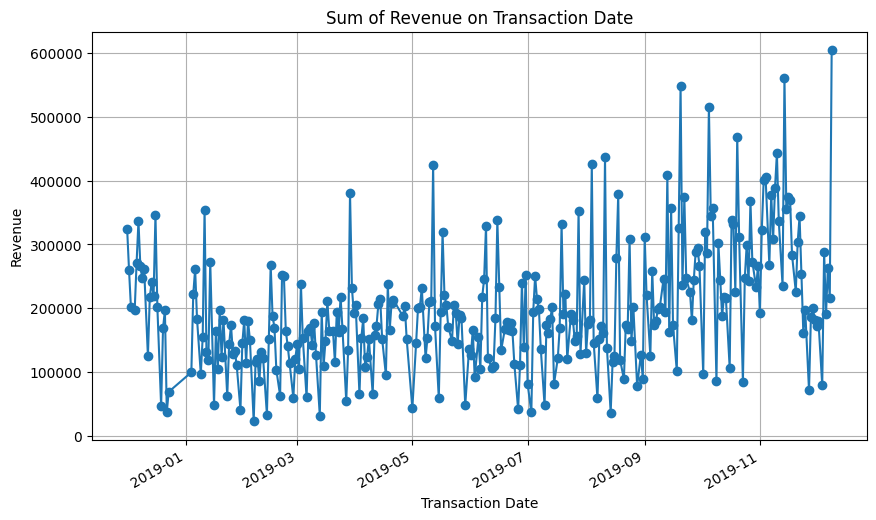

In [15]:
# Plotting the sum of revenue on each transaction date
df_revenue_by_date = df_pandas.groupby('transaction_date')['Revenue'].sum()

# Plotting the results
plt.figure(figsize=(10, 6))
df_revenue_by_date.plot(kind='line', marker='o')
plt.title("Sum of Revenue on Transaction Date")
plt.ylabel("Revenue")
plt.xlabel("Transaction Date")
plt.grid(True)
plt.show()

#### Question 1.3

**1.3.1 Analyzing Average Revenue by Workday**

To identify which day of the week generates the most sales, we first extract the day of the week from the `transaction_date`. We then calculate the average revenue for each day of the week and plot this information to visualize which day yields the highest average revenue.

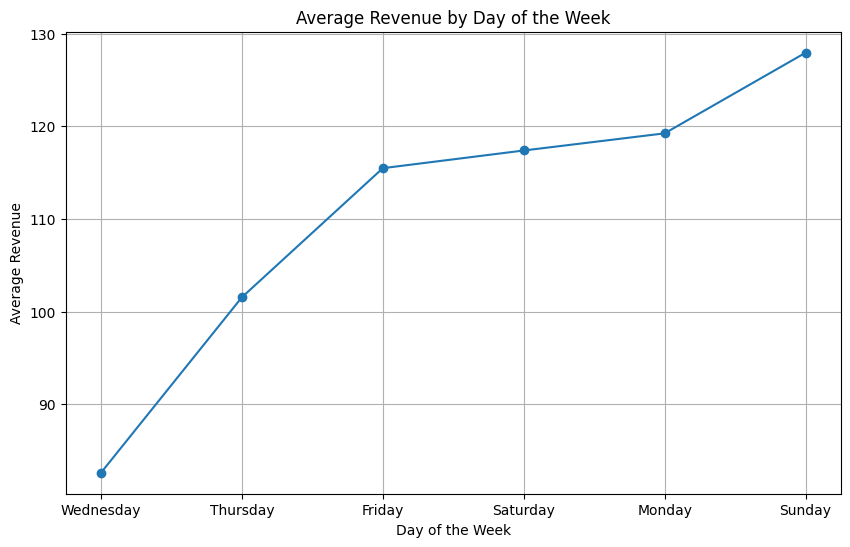

In [16]:
# Extracting the day of the week from transaction date
df_pandas['day_of_week'] = df_pandas['transaction_date'].dt.day_name()

# Calculating the average revenue per day of the week
avg_revenue_per_day = df_pandas.groupby('day_of_week')['Revenue'].mean().sort_values()

# Plotting the average revenue per day of the week
plt.figure(figsize=(10, 6))
avg_revenue_per_day.plot(kind='line', marker='o')
plt.title("Average Revenue by Day of the Week")
plt.ylabel("Average Revenue")
plt.xlabel("Day of the Week")
plt.grid(True)
plt.show()

**1.3.2 Identifying Top Products on the Highest Revenue Workday**

From the previous analysis, we determine the day of the week with the highest average revenue. We then filter the data for that specific workday and identify:
*   The product that generates the highest revenue.
*   The product with the highest sales volume (quantity).

In [17]:
# Finding the day of the week with the highest average revenue
top_workday = avg_revenue_per_day.idxmax()

# Filtering data for that workday
filtered_df = df_pandas[df_pandas['day_of_week'] == top_workday]

# Finding the product with the highest revenue on that workday
highest_revenue_product = filtered_df.groupby('productName_process')['Revenue'].sum().idxmax()

# Finding the product with the highest sales volume on that workday
highest_volume_product = filtered_df.groupby('productName_process')['Quantity'].sum().idxmax()

print(f"Product with highest revenue on {top_workday}: {highest_revenue_product}")
print(f"Product with highest sales volume on {top_workday}: {highest_volume_product}")


Product with highest revenue on Sunday: WorldWarGlidersAsstdDesigns
Product with highest sales volume on Sunday: WorldWarGlidersAsstdDesigns


**1.3.3 Plotting Top Products by Revenue and Sales Volume**

Finally, we create two plots:
*   The top 5 products by overall revenue.
*   The top 5 products by overall sales volume.

which help in understanding which products are the most successful in terms of revenue and sales volume.

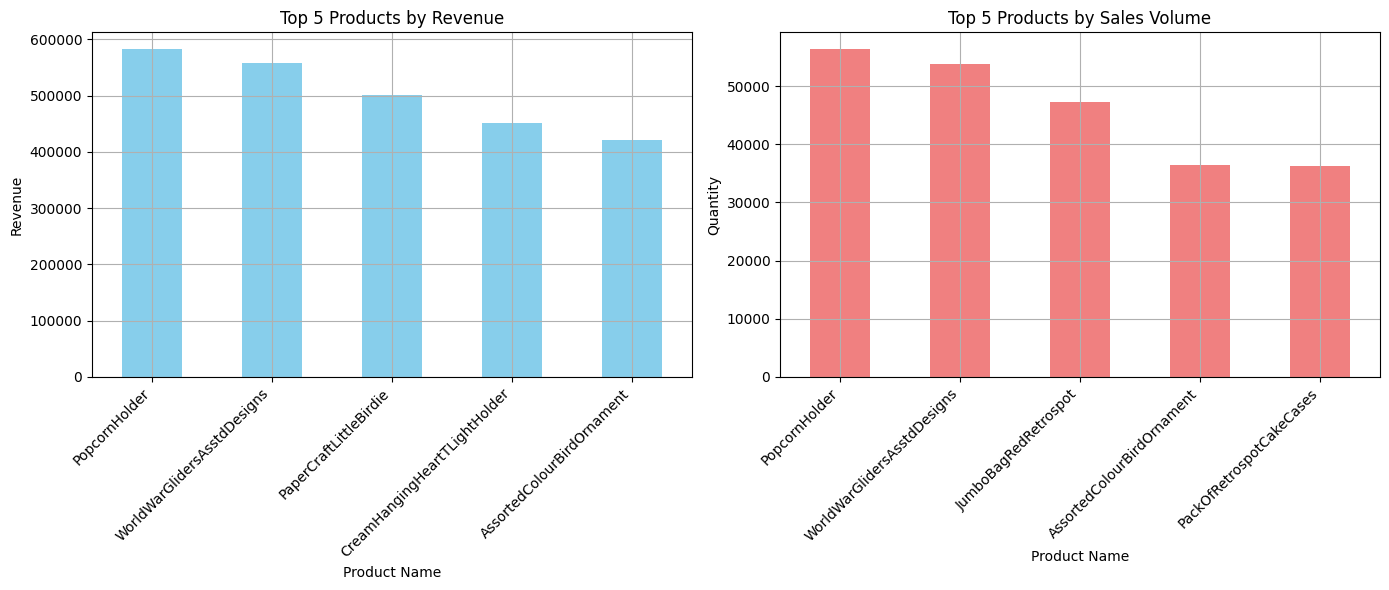

In [18]:
# Top 5 products by revenue
top_5_revenue_products = df_pandas.groupby('productName_process')['Revenue'].sum().nlargest(5)

# Top 5 products by sales volume
top_5_volume_products = df_pandas.groupby('productName_process')['Quantity'].sum().nlargest(5)

# Plotting the results
plt.figure(figsize=(14, 6))

# Plot for top 5 revenue products
plt.subplot(1, 2, 1)
top_5_revenue_products.plot(kind='bar', color='skyblue')
plt.title("Top 5 Products by Revenue")
plt.xlabel("Product Name")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Plot for top 5 volume products
plt.subplot(1, 2, 2)
top_5_volume_products.plot(kind='bar', color='lightcoral')
plt.title("Top 5 Products by Sales Volume")
plt.xlabel("Product Name")
plt.ylabel("Quantity")
plt.xticks(rotation=45, ha='right')
plt.grid(True)

plt.tight_layout()
plt.show()


#### Question 1.4

**1.4.1 Identifying the Country with the Highest Revenue**

To determine which country generates the highest revenue, we group the data by `Country` and sum the `Revenue` for each country. The country with the highest total revenue is identified.

In [19]:
# Aggregating revenue by country
revenue_by_country = df_pandas.groupby('Country')['Revenue'].sum()

# Identifying the country with the highest revenue
top_country = revenue_by_country.idxmax()
top_country_revenue = revenue_by_country.max()

**1.4.2 Finding the Month with the Highest Revenue in the Top Country**

For the country with the highest revenue, we create a filtered `DataFrame` containing only data from that country. We then extract the month from the `transaction_date` and find the month with the highest total revenue in that country.

In [20]:
# Aggregating revenue by month for the top country
df_pandas['month'] = df_pandas['transaction_date'].dt.to_period('M')
revenue_by_month = df_pandas[df_pandas['Country'] == top_country].groupby('month')['Revenue'].sum()

# Identifying the month with the highest revenue in that country
top_month = revenue_by_month.idxmax()
top_month_revenue = revenue_by_month.max()

print(f"Country with highest revenue: {top_country} (${top_country_revenue})")
print(f"Month with highest revenue in {top_country}: {top_month} (${top_month_revenue})")

Country with highest revenue: United Kingdom ($49994030.344613075)
Month with highest revenue in United Kingdom: 2019-11 ($6737639.98568058)


#### Question 1.5

**1.5.1 Determining Shopping Frequency**

To identify the customer who shops most frequently, we first filter out transactions where `Quantity` is less than or equal to 0, as these do not represent shopping activity. We then calculate the distinct count of `TransactionNo` for each customer and find the customer with the highest count.

In [21]:
# Filtering out transactions where Quantity is less than or equal to 0
filtered_transactions = df_pandas[df_pandas['Quantity'] > 0]
# Finding the customer with the highest distinct count of transactionNo
most_frequent_customer = filtered_transactions.groupby('CustomerNo')['TransactionNo'].nunique().idxmax()
print(f"Customer with the highest distinct count of transactions: {most_frequent_customer}")

Customer with the highest distinct count of transactions: 12748


**1.5.2 Finding Products Typically Purchased**

For the most frequent customer, we filter the transactions specific to that `CustomerNo` and then analyze the products they typically buy based on the `Quantity` of products purchased. We determine the top products by summing the quantities for each product.

In [22]:
# Filtering the data for this specific customer
customer_df = filtered_transactions[filtered_transactions['CustomerNo'] == most_frequent_customer]
# Finding the products typically bought by this customer based on the sum of the Quantity purchased
top_products = customer_df.groupby('productName_process')['Quantity'].sum().sort_values(ascending=False).head()

print(f"Products typically bought by customer {most_frequent_customer} based on quantity:")
print(top_products)

Products typically bought by customer 12748 based on quantity:
productName_process
VictorianMetalPostcardSpring     595
WorldWarGlidersAsstdDesigns      480
RoseScentCandleJewelledDrawer    408
CartoonPencilSharpeners          405
SmallWhiteRetrospotMugInBox      390
Name: Quantity, dtype: int64


#### Question 1.6

**1.6.1 Grouping Product Information by Transaction**

As part of the basket-level analysis, we start by filtering the dataframe to include only valid purchases where the `Quantity` is greater than 0. After filtering, we group the transactions by `TransactionNo` to aggregate product information at the transaction level. Specifically, we:

*   Group and aggregate the `Product_category` values into a list, which helps in tracking the product categories bought in the same transaction.
*   Group and aggregate the `productName_process` values into a list to capture the specific products purchased during each transaction.

The resulting dataframe `grouped_df` provides a transaction-level view of the product categories and product names purchased together.



In [23]:
# Filtering the dataframe to include only rows where Quantity > 0
filtered_df = df_pandas[df_pandas['Quantity'] > 0]

# Grouping by transactionNo and aggregate product_category and productName_process into lists
grouped_df = filtered_df.groupby('TransactionNo').agg({
    'Product_category': lambda x: list(x),  # Aggregate product_category into a list
    'productName_process': lambda x: list(x)  # Aggregate productName_process into a list
}).reset_index()

**1.6.2 Removing Adjacent Duplicates from Product Categories**

In this step, we address the issue of adjacent duplicate entries within the `Product_category` lists obtained from the previous step. Specifically, for each transaction, we process the `Product_category` column to remove any duplicates that appear consecutively, ensuring that the sequence of product categories is unique for adjacent elements. For example, a list such as `[product category 1, product category 1, product category 2]` will be processed as `[product category 1, product category 2]`.

To achieve this, we:

*   Define a custom function `remove_adjacent_duplicates`, which iterates through the list of product categories and removes adjacent duplicates.
*   Apply this function to the `Product_category` column, creating a new column `product_category_processed` in the dataframe.
*   Save the processed dataframe as `df_1` and print the top 10 rows for verification.

In [24]:
# Functioning to remove adjacent duplicates from a list
def remove_adjacent_duplicates(category_list):
    if not category_list:
        return []
    result = [category_list[0]]
    for item in category_list[1:]:
        if item != result[-1]:  # Only adding if it's different from the last element in result
            result.append(item)
    return result

# Applying the function to the product_category column
grouped_df['product_category_processed'] = grouped_df['Product_category'].apply(remove_adjacent_duplicates)

# Creating the final processed dataframe (df_1) and displaying the top 10 rows
df_1 = grouped_df[['TransactionNo', 'product_category_processed', 'productName_process']]
pd.set_option('display.max_colwidth', None)
df_1.head(10)

,TransactionNo,product_category_processed,productName_process
0,536365,[0ca],"[CreamHangingHeartTLightHolder, WhiteMoroccanMetalLantern, CreamCupidHeartsCoatHanger, KnittedUnionFlagHotWaterBottle, RedWoollyHottieWhiteHeart, SetBabushkaNestingBoxes, GlassStarFrostedTLightHolder]"
1,536366,[0ca],"[HandWarmerUnionJack, HandWarmerRedRetrospot]"
2,536367,[0ca],"[AssortedColourBirdOrnament, PoppysPlayhouseBedroom, PoppysPlayhouseKitchen, FeltcraftPrincessCharlotteDoll, IvoryKnittedMugCosy, BoxOfAssortedColourTeaspoons, BoxOfVintageJigsawBlocks, HomeBuildingBlockWord, LoveBuildingBlockWord, RecipeBoxWithMetalHeart, DoormatNewEngland, BoxOfVintageAlphabetBlocks]"
3,536368,[0ca],"[JamMakingSetWithJars, RedCoatRackParisFashion, YellowCoatRackParisFashion, BlueCoatRackParisFashion]"
4,536369,[0ca],[BathBuildingBlockWord]
5,536370,[0ca],"[AlarmClockBakelikePink, AlarmClockBakelikeRed, AlarmClockBakelikeGreen, PandaAndBunniesStickerSheet, StarsGiftTape, InflatablePoliticalGlobe, VintageHeadsAndTailsCardGame, SetRedRetrospotTeaTowels, RoundSnackBoxesSetOfWoodland, SpaceboyLunchBox, LunchBoxILoveLondon, CircusParadeLunchBox, CharlotteBagDollyGirlDesign, RedToadstoolLedNightLight, SetTeaTowelsILoveLondon, VintageSeasideJigsawPuzzles, MiniJigsawCircusParade, MiniJigsawSpaceboy, MiniPaintSetVintage]"
6,536371,[0ca],[PaperChainKitSChristmas]
7,536372,[0ca],"[HandWarmerRedRetrospot, HandWarmerUnionJack]"
8,536373,[0ca],"[CreamHangingHeartTLightHolder, WhiteMoroccanMetalLantern, CreamCupidHeartsCoatHanger, EdwardianParasolRed, RetroCoffeeMugsAssorted, SaveThePlanetMug, VintageBillboardDrinkMeMug, VintageBillboardLoveHateMug, WoodDrawerCabinetWhiteFinish, DrawerAntiqueWhiteWoodCabinet, WoodenPictureFrameWhiteFinish, WoodenFrameAntiqueWhite, KnittedUnionFlagHotWaterBottle, RedWoollyHottieWhiteHeart, SetBabushkaNestingBoxes, GlassStarFrostedTLightHolder]"
9,536374,[0ca],[VictorianSewingBoxLarge]


#### Question 1.7

**1.7.1 Calculate the Product Category List Length**

We first create a new column `prod_len` to determine the length of the list in the `product_category_processed` column for each transaction. This helps in understanding how many different product categories are involved in each transaction. After adding the `prod_len` column, we display the first five rows of the dataframe `df_1` to verify the addition.

In [25]:
# Adding 'prod_len' Column
df_1['prod_len'] = df_1['product_category_processed'].apply(len)
print("First five rows of df_1 with 'prod_len':")
df_1.head()

First five rows of df_1 with 'prod_len':


,TransactionNo,product_category_processed,productName_process,prod_len
0,536365,[0ca],"[CreamHangingHeartTLightHolder, WhiteMoroccanMetalLantern, CreamCupidHeartsCoatHanger, KnittedUnionFlagHotWaterBottle, RedWoollyHottieWhiteHeart, SetBabushkaNestingBoxes, GlassStarFrostedTLightHolder]",1
1,536366,[0ca],"[HandWarmerUnionJack, HandWarmerRedRetrospot]",1
2,536367,[0ca],"[AssortedColourBirdOrnament, PoppysPlayhouseBedroom, PoppysPlayhouseKitchen, FeltcraftPrincessCharlotteDoll, IvoryKnittedMugCosy, BoxOfAssortedColourTeaspoons, BoxOfVintageJigsawBlocks, HomeBuildingBlockWord, LoveBuildingBlockWord, RecipeBoxWithMetalHeart, DoormatNewEngland, BoxOfVintageAlphabetBlocks]",1
3,536368,[0ca],"[JamMakingSetWithJars, RedCoatRackParisFashion, YellowCoatRackParisFashion, BlueCoatRackParisFashion]",1
4,536369,[0ca],[BathBuildingBlockWord],1


**1.7.2 Transforming Product Category List into Path Format**

In this task, we transform the `product_category_processed` column from a list format into a sequence of transitions representing the customer’s journey, starting from 'start' and ending with 'conversion'. The format of the transformation follows this structure: `'start > productcategory1 > productcategory2 > ... > conversion'`.

To achieve this, we define a function `data_processing` that filters the dataframe based on the length of the product category list (`prod_len`), and then applies a transformation to create the `path` for each transaction.



In [26]:
# Defining the data_processing function
def data_processing(df, maxlength=3, minlength=1):
    # Filtering dataframe based on prod_len
    filtered_df = df[(df['prod_len'] <= maxlength) & (df['prod_len'] >= minlength)].copy()

    # Functioning to transform list to 'start > ... > conversion' format
    def transform_to_path(category_list):
        if not category_list:
            return 'start > conversion'
        return 'start > ' + ' > '.join(category_list) + ' > conversion'

    # Applying the transformation to the 'product_category_processed' column
    filtered_df['path'] = filtered_df['product_category_processed'].apply(transform_to_path)

    # Returning the new dataframe with 'path' column
    return filtered_df[['TransactionNo', 'product_category_processed', 'prod_len', 'path']]

# Applying the data_processing function to df_1
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# Printing the top 10 rows of the new dataframe df_2
print("Top 10 rows of df_2:")
df_2.head(10)

Top 10 rows of df_2:


,TransactionNo,product_category_processed,prod_len,path
13,536378,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
27,536395,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
36,536404,"[0ca, 1ca, 0ca, 4ca, 0ca]",5,start > 0ca > 1ca > 0ca > 4ca > 0ca > conversion
40,536408,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
42,536412,"[0ca, 4ca, 0ca]",3,start > 0ca > 4ca > 0ca > conversion
43,536415,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
52,536464,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
72,536532,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
82,536542,"[0ca, 4ca]",2,start > 0ca > 4ca > conversion
83,536544,"[0ca, 1ca, 0ca, 4ca, 0ca]",5,start > 0ca > 1ca > 0ca > 4ca > 0ca > conversion


#### Question 1.8

**1.8.1 Count the Transactions Ending with Specific Patterns**

We define a function `count_end_patterns` that iterates through a list of patterns, checks whether the path column ends with each specified pattern (from the question) followed by > conversion, and counts how many transactions match the pattern.




In [27]:
# Counting Transactions Ending with Specific Patterns
def count_end_patterns(df, patterns):
    counts = {}
    for pattern in patterns:
        pattern_str = f" > {pattern} > conversion"
        counts[pattern] = df['path'].str.endswith(pattern_str).sum()
    return counts

patterns_end = ['0ca', '1ca', '2ca', '3ca', '4ca']
end_counts = count_end_patterns(df_2, patterns_end)
print("Counts for patterns ending with 'conversion':", end_counts)

Counts for patterns ending with 'conversion': {'0ca': 3056, '1ca': 26, '2ca': 144, '3ca': 68, '4ca': 198}


**1.8.2 Counting Specific Patterns in Transactions**

We define another function `count_specific_patterns` that takes a dataframe and a list of patterns, and counts how many times each pattern appears in the `path` column (which we created in 1.7.2). It uses the `str.count()` method to find occurrences within each transaction and sums the counts across all transactions.

In [28]:
# Counting Specific Patterns in Transactions
def count_specific_patterns(df, patterns):
    counts = {}
    for pattern in patterns:
        pattern_str = f" > {pattern}"
        counts[pattern] = df['path'].str.count(pattern_str).sum()
    return counts

patterns_specific = ['0ca > 0ca', '0ca > 1ca', '0ca > 2ca', '0ca > 3ca', '0ca > 4ca', '0ca > conversion']
specific_counts = count_specific_patterns(df_2, patterns_specific)
print("Counts for specific patterns:", specific_counts)

Counts for specific patterns: {'0ca > 0ca': 0, '0ca > 1ca': 1222, '0ca > 2ca': 1137, '0ca > 3ca': 343, '0ca > 4ca': 1198, '0ca > conversion': 3056}


**1.8.3 Count the Transactions Containing the Pattern ‘... > 0ca > ...’**



*   Define the `pattern_including_0ca` which represent ` > 0ca >
*   Count the occurences of the pattern by using `str.count()`method. It counts how many times the pattern appears within the `path` column for each transaction. The counts are then summed across all transactions to get the total number of occurrences.





In [29]:
# Counting Transactions Containing Pattern '... > 0ca > ...'
pattern_including_0ca = ' > 0ca > '
count_including_0ca = df_2['path'].str.count(pattern_including_0ca).sum()
print("Count for '... > 0ca > ...':", count_including_0ca)

Count for '... > 0ca > ...': 6956


**1.8.4 Calculate the Final Result by Using the Results from 1.8.2 and 1.8.3**


*   Sum the counts from 1.8.2
*   Divide the result from 1.8.3 by the sum of counts from 1.8.2. If the sum of the counts from 1.8.2 is zero, set the result as 0 to avoid 0 division by zero.



In [30]:
# Performing the Calculation
total_specific_counts = sum(specific_counts.values())
result = count_including_0ca / total_specific_counts if total_specific_counts != 0 else 0
print("Result for 1.8.4:", result)

Result for 1.8.4: 1.0


#### Question 1.9

**1.9.1 Build a Transaction-Level Product DataFrame**

We construct a transaction-level product dataframe, where each row represents a `TransactionNo`, and each product becomes a column. The value in each column corresponds to the `Quantity` of the product purchased in that transaction.

The dataframe has:

*   Filter out transactions with negative `Quantity`
*   Select the top 100 products by total `Quantity`



In [31]:
# Filter out transactions with negative Quantity values
filtered_df = df_pandas[df_pandas['Quantity'] > 0]

# Calculate the total quantity sold for each product and keep the top 100 products
top_100_products = filtered_df.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter the dataframe to include only the top 100 products
filtered_df_top_100 = filtered_df[filtered_df['productName_process'].isin(top_100_products)]

# Pivot the dataframe to create the transaction-level product dataframe
# Each row represents TransactionNo, and each product becomes a column with the Quantity as the value
transaction_level_df = filtered_df_top_100.pivot_table(
    index='TransactionNo',
    columns='productName_process',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# Display the transaction-level product dataframe
transaction_level_df.head()

productName_process,AgedGlassSilverTLightHolder,AntiqueSilverTLightGlass,AssortedColourBirdOrnament,AssortedColoursSilkFan,AssortedFlowerColourLeis,AsstdDesigndPaperStickers,BaggSwirlyMarbles,BlackRecordCoverFrame,BrocadeRingPurse,BubblegumRingAssorted,...,StrawberryCharlotteBag,SweetheartFairyCakeCases,TeatimeFairyCakeCases,TravelCardWalletKeepCalm,VictorianGlassHangingTLight,VintageSnapCards,WoodenHeartChristmasScandinavian,WoodenStarChristmasScandinavian,WoodlandCharlotteBag,WorldWarGlidersAsstdDesigns
TransactionNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**1.9.2 Run the Apriori Algorithm to idenitfy the items with minimum support of 1.5%**

We use the `mlxtend.frequent_patterns` module to idenitfy the items by followings:



*   Filter out transactions (baskets) with fewer than 4 items.
*   Use One-Hot Encoding to convert the `DataFrame` from `quantities` to `boolean` values. This is because the apriori algorith requires a boolean DataFrame.
*   Apply apriori with a minimum support of 1.5% to identify the items.
*   List item







In [32]:
# Filter the transactions with 4 or more items
# Create a new column that counts the number of non-zero quantities in each transaction (i.e., the number of products in each basket)
transaction_level_df['num_items'] = (transaction_level_df > 0).sum(axis=1)

# Filter to keep only transactions with 4 or more items
filtered_transactions = transaction_level_df[transaction_level_df['num_items'] >= 4].drop(columns=['num_items'])

# Convert the DataFrame to boolean values (1 if product is present, 0 if not)
transaction_level_df_bool = (filtered_transactions > 0)

# Apply the Apriori algorithm with a minimum support of 1.5%
frequent_itemsets = apriori(transaction_level_df_bool, min_support=0.015, use_colnames=True)

# Display the frequent itemsets
frequent_itemsets.head()


,support,itemsets
0,0.031276,(AgedGlassSilverTLightHolder)
1,0.085835,(AntiqueSilverTLightGlass)
2,0.126928,(AssortedColourBirdOrnament)
3,0.054698,(AssortedColoursSilkFan)
4,0.057083,(BaggSwirlyMarbles)


Interpretation:

The apriori algotihm has identified the five frequently purchased items are 'AgedGlassSilverTLightHolder', 'AntiqueSilverTLightGlass', 'AssortedColourBirdOrnament', 'AssortedColoursSilkFan', and 'BaggSwirlyMarbles' with their corresponding support values indicating how often they appear in transactions. Among these, "AssortedColourBirdOrnament" is the most frequently bought item, appearing in approximately 12.69% of all transactions.


**1.9.3 Finding Items with Support ≥ 1.0% and Lift > 10**

In [33]:
# Apply the Apriori algorithm with a minimum support of 1.0%
frequent_itemsets = apriori(transaction_level_df_bool, min_support=0.01, use_colnames=True)

# Display the frequent itemsets with support ≥ 1.0%
print("Frequent itemsets with support ≥ 1.0%:")
print(frequent_itemsets.head())

# Generate the association rules
from mlxtend.frequent_patterns import association_rules

# Generate association rules with the minimum support found earlier
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=10)

# Filter rules with lift > 10
filtered_rules = rules[rules['lift'] > 10]

# Display the filtered rules with lift > 10
print("Association rules with lift > 10:")
filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


Frequent itemsets with support ≥ 1.0%:
    support                       itemsets
0  0.031276  (AgedGlassSilverTLightHolder)
1  0.085835     (AntiqueSilverTLightGlass)
2  0.126928   (AssortedColourBirdOrnament)
3  0.054698       (AssortedColoursSilkFan)
4  0.010799     (AssortedFlowerColourLeis)
Association rules with lift > 10:


,antecedents,consequents,support,confidence,lift
0,(WoodenStarChristmasScandinavian),(WoodenHeartChristmasScandinavian),0.042637,0.800000,14.551020
1,(WoodenHeartChristmasScandinavian),(WoodenStarChristmasScandinavian),0.042637,0.775510,14.551020
2,"(AntiqueSilverTLightGlass, WoodenStarChristmasScandinavian)",(WoodenHeartChristmasScandinavian),0.010519,0.815217,14.827806
3,"(AntiqueSilverTLightGlass, WoodenHeartChristmasScandinavian)",(WoodenStarChristmasScandinavian),0.010519,0.862069,16.175136
4,(WoodenStarChristmasScandinavian),"(AntiqueSilverTLightGlass, WoodenHeartChristmasScandinavian)",0.010519,0.197368,16.175136


**1.9.4 Explore Patterns by Using Different Support, Confidence, and Lift Thresholds**

Explore the patterns by following different setting:

| **Example** | **Support Threshold** | **Confidence Threshold** | **Lift Threshold** |
|-------------|-----------------------|--------------------------|--------------------|
| Example 1   | 2%                    | 50%                      | 5                  |
| Example 2   | 1.5%                  | 60%                      | 7                  |
| Example 3   | 1%                    | 70%                      | 8                  |



In [34]:
# Applying Apriori with different support thresholds

# Example 1: Minimum support = 0.02 (2%)
frequent_itemsets_1 = apriori(transaction_level_df_bool, min_support=0.02, use_colnames=True)
rules_1 = association_rules(frequent_itemsets_1, metric="confidence", min_threshold=0.5)  # Confidence ≥ 50%
rules_1 = rules_1[rules_1['lift'] > 5]  # Lift > 5

# Example 2: Minimum support = 0.015 (1.5%)
frequent_itemsets_2 = apriori(transaction_level_df_bool, min_support=0.015, use_colnames=True)
rules_2 = association_rules(frequent_itemsets_2, metric="confidence", min_threshold=0.6)  # Confidence ≥ 60%
rules_2 = rules_2[rules_2['lift'] > 7]  # Lift > 7

# Example 3: Minimum support = 0.01 (1%), confidence = 70%, and lift > 8
frequent_itemsets_3 = apriori(transaction_level_df_bool, min_support=0.01, use_colnames=True)
rules_3 = association_rules(frequent_itemsets_3, metric="confidence", min_threshold=0.7)  # Confidence ≥ 70%
rules_3 = rules_3[rules_3['lift'] > 8]  # Lift > 8

# Displaying results for all three examples
print("Example 1: Rules with support ≥ 2%, confidence ≥ 50%, lift > 5")
rules_1[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


Example 1: Rules with support ≥ 2%, confidence ≥ 50%, lift > 5


,antecedents,consequents,support,confidence,lift
1,(CharlotteBagPinkPolkadot),(CharlotteBagSukiDesign),0.056381,0.574286,5.067645
2,(CharlotteBagPinkPolkadot),(RedRetrospotCharlotteBag),0.072230,0.735714,5.447189
3,(RedRetrospotCharlotteBag),(CharlotteBagPinkPolkadot),0.072230,0.534787,5.447189
4,(CharlotteBagPinkPolkadot),(StrawberryCharlotteBag),0.052314,0.532857,5.538297
5,(StrawberryCharlotteBag),(CharlotteBagPinkPolkadot),0.052314,0.543732,5.538297


In [35]:
print("\nExample 2: Rules with support ≥ 1.5%, confidence ≥ 60%, lift > 7")
rules_2[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


Example 2: Rules with support ≥ 1.5%, confidence ≥ 60%, lift > 7


,antecedents,consequents,support,confidence,lift
18,(WoodenStarChristmasScandinavian),(WoodenHeartChristmasScandinavian),0.042637,0.800000,14.551020
19,(WoodenHeartChristmasScandinavian),(WoodenStarChristmasScandinavian),0.042637,0.775510,14.551020
23,"(CakeCasesVintageChristmas, PaperChainKitSChristmas)",(PaperChainKitVintageChristmas),0.023983,0.678571,7.816178
26,"(CharlotteBagSukiDesign, ChilliLights)",(CharlotteBagPinkPolkadot),0.015007,0.690323,7.031429
43,"(CharlotteBagSukiDesign, PackOfRetrospotCakeCases)",(CharlotteBagPinkPolkadot),0.026367,0.691176,7.040126


In [36]:
print("\nExample 3: Rules with support ≥ 1%, confidence ≥ 70%, lift > 8")
rules_3[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


Example 3: Rules with support ≥ 1%, confidence ≥ 70%, lift > 8


,antecedents,consequents,support,confidence,lift
4,(WoodenStarChristmasScandinavian),(WoodenHeartChristmasScandinavian),0.042637,0.800000,14.551020
5,(WoodenHeartChristmasScandinavian),(WoodenStarChristmasScandinavian),0.042637,0.775510,14.551020
32,"(AntiqueSilverTLightGlass, WoodenStarChristmasScandinavian)",(WoodenHeartChristmasScandinavian),0.010519,0.815217,14.827806
33,"(AntiqueSilverTLightGlass, WoodenHeartChristmasScandinavian)",(WoodenStarChristmasScandinavian),0.010519,0.862069,16.175136
42,"(BaggSwirlyMarbles, PaperChainKitSChristmas)",(PaperChainKitVintageChristmas),0.011641,0.747748,8.612991


Intepretation:

<u>Example 1: Support ≥ 2%, Confidence ≥ 50%, Lift > 5</u>

- "CharlotteBagPinkPolkadot" and "CharlotteBagSukiDesign" have a strong association with a lift of 5.07, indicating frequent co-purchases.
- Other Charlotte bag variants (e.g., "RedRetrosportCharlotteBag" and "StrawberryCharlotteBag") also appear with significant lifts.

- From the above, customers who purchase one specific style of Charlotte bag often buy similar designs. This highlights a strong brand or style loyalty, suggesting an opportunity for promoting related products or bundling offers.


<u> Example 2: Support ≥ 1.5%, Confidence ≥ 60%, Lift > 7 </u>

- "WoodenHeartChristmasScandinavian" and "WoodenStarChristmasScandinavian" show a lift of 14.55 with a confidence of 77.5% and 80%, reinforcing their complementary relationship.
- "CakeCasesVintageChristmas" and "PaperChainKitScChristmas" have a lift of 7.81, suggesting a thematic purchasing trend around Christmas decorations.

- From the above, seasonal items are frequently bought together, particularly around Christmas, indicating a potential for themed bundles or promotions targeting holiday shoppers.

<u> Example 3: Support ≥ 1%, Confidence ≥ 70%, Lift > 8 </u>

- Again, "WoodenHeartChristmasScandinavian" and "WoodenStarChristmasScandinavian" stand out with a lift of 14.55 and high confidence.
- The addition of "AntiqueSilverTLightGlass" to the same rule set results in an even higher lift of 16.17, indicating that customers buying these themed Christmas items are also likely to purchase decorative items like tealight holders.
- From the above, this set reveals even stronger relationships between Christmas-themed items and suggests cross-selling opportunities, particularly between decorative and holiday-themed products. Promotions targeting customers interested in one item should include recommendations for the others in the set.


<u>Sumamry</u>
- Charlotte Bag Loyalty: There is a strong association between different variants of the Charlotte bags, indicating brand loyalty or design preferences, which can be leveraged for cross-promotions.
- Christmas-Themed Items: Customers purchasing holiday items, especially Scandinavian-style Christmas decorations, are highly likely to buy complementary items, offering an opportunity for bundled holiday promotions.
- High Confidence and Lift: Across all examples, rules with high confidence and lift indicate strong purchasing patterns that can inform targeted marketing strategies, especially during seasonal promotions.

#### Question 1.10

**1.10.1 Build a Customer-Product DataFrame**

We first filter out the dataframe that the have negative `Quantity` and only select top 100 products.

Then we use the `pivot_table` function to create a matrix where each row represents a customer (`CustomerNo`), and each column represents a product. The values in the table are the aggregated `Quantity` of that product purchased by each customer.

In [37]:
# Filter out transactions with negative quantity values
filtered_df = df_pandas[df_pandas['Quantity'] > 0]

# Calculate the total quantity sold for each product and keep the top 100 products
top_100_products = filtered_df.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter the dataframe to include only the top 100 products
filtered_top_100_df = filtered_df[filtered_df['productName_process'].isin(top_100_products)]

# Create the customer-product dataframe
# Pivot the dataframe such that each row is a customer (CustomerNo) and each product becomes a column
# The values in the columns represent the aggregated Quantity of that product for each customer
CustomerProduct_df = filtered_top_100_df.pivot_table(
    index='CustomerNo',
    columns='productName_process',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# Display the resulting customer-product dataframe
print("Customer-Product DataFrame (Top 5 rows):")
CustomerProduct_df.head()

Customer-Product DataFrame (Top 5 rows):


productName_process,AgedGlassSilverTLightHolder,AntiqueSilverTLightGlass,AssortedColourBirdOrnament,AssortedColoursSilkFan,AssortedFlowerColourLeis,AsstdDesigndPaperStickers,BaggSwirlyMarbles,BlackRecordCoverFrame,BrocadeRingPurse,BubblegumRingAssorted,...,StrawberryCharlotteBag,SweetheartFairyCakeCases,TeatimeFairyCakeCases,TravelCardWalletKeepCalm,VictorianGlassHangingTLight,VintageSnapCards,WoodenHeartChristmasScandinavian,WoodenStarChristmasScandinavian,WoodlandCharlotteBag,WorldWarGlidersAsstdDesigns
CustomerNo,,,,,,,,,,,,,,,,,,,,,
12004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12008,1,40,0,0,0,0,0,0,0,0,...,0,0,0,0,3,2,0,0,0,0
12025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12026,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,1,1
12031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**1.10.2 Calculate the Pairwise Euclidean Distance on Customer Level**

We based on the customer-product dataframe from question 1.10.1 to calculate the Pairwise Euclidean distance on the customer level. First, we use the product `Quantity` information for each customer to calculate the `Euclidean distance` between all customers.

In [38]:
# Calculate the pairwise Euclidean distances between customers
# The 'pdist' function computes the pairwise distances between rows of the dataframe
# The 'squareform' function converts the condensed distance matrix into a square matrix
euclidean_distances = pdist(CustomerProduct_df, metric='euclidean')
euclidean_distance_matrix = squareform(euclidean_distances)

# Convert the distance matrix to a DataFrame for better readability
distance_matrix_df = pd.DataFrame(
    euclidean_distance_matrix,
    index=CustomerProduct_df.index,  # Set the CustomerNo as the row index
    columns=CustomerProduct_df.index  # Set the CustomerNo as the column headers
)

# Display the pairwise Euclidean distance matrix (first 5 rows and columns for brevity)
print("Pairwise Euclidean Distance Matrix (Top 5 rows and columns):")
distance_matrix_df.iloc[:5, :5]

Pairwise Euclidean Distance Matrix (Top 5 rows and columns):


CustomerNo,12004,12008,12025,12026,12031
CustomerNo,,,,,
12004,0.000000,42.130749,13.152946,10.049876,9.949874
12008,42.130749,0.000000,43.474130,41.737274,42.308392
12025,13.152946,43.474130,0.000000,15.231546,9.899495
12026,10.049876,41.737274,15.231546,0.000000,9.695360
12031,9.949874,42.308392,9.899495,9.695360,0.000000


In [39]:
# Check if CustomerNo 13069 is present in the distance matrix
if '13069' in distance_matrix_df.index:
    print("CustomerNo 13069 is present in the distance matrix.")
else:
    print("CustomerNo 13069 is not present in the distance matrix.")


CustomerNo 13069 is present in the distance matrix.


**1.10.3 Identify the Top Most Similar Customers to 13069 and 17490**

In [40]:
# Define a function to find the top 3 most similar customers based on Euclidean distance
def find_top_3_similar(customerno, distance_matrix):
    # Get the distances for the specified customer
    customer_distances = distance_matrix.loc[customerno]

    # Sort the distances and exclude the customer itself (distance = 0)
    similar_customers = customer_distances.sort_values()[1:4]  # Exclude self (first entry) and get top 3

    return similar_customers

# Find the top 3 most similar customers for CustomerNo == 13069
top_3_customers_13069 = find_top_3_similar('13069', distance_matrix_df)
print(f"Top 3 most similar customers to CustomerNo 13069:\n{top_3_customers_13069}")

# Find the top 3 most similar customers for CustomerNo == 17490
top_3_customers_17490 = find_top_3_similar('17490', distance_matrix_df)
print(f"Top 3 most similar customers to CustomerNo 17490:\n{top_3_customers_17490}")

Top 3 most similar customers to CustomerNo 13069:
CustomerNo
15118     598.369451
17523    1449.092820
18179    1734.755891
Name: 13069, dtype: float64
Top 3 most similar customers to CustomerNo 17490:
CustomerNo
12519    26.00000
12582    26.00000
12652    26.70206
Name: 17490, dtype: float64


**1.10.4 Recommendations for CustomerNo 13069**

Since there are some products that CustomerNo 13069 has never shopped before. We suggest using the below two recommendation system which could help to recommend most relevant products to the him/her:

Option 1: Collaborative Filtering
This recommendation system assume customers with similar past purchasing behaviors will likely have similar purchasing preferences. So, based on the 1.10.3 result, we can see the top 3 most simialr customers to CustomerNo 13069 are 15118, 17523 and 18179. We can first retrieve the list of products purchased by these similar customers. Then compare the similarity of purchased products between these similar customers and CustomerNo 13069. If we find there are products which purchased by these customers but CustomerNo 13069 still hasn't bought yet. We can recommend these products to CustomerNo 13069.

Option 2: Content-Based Filtering
This recommendation on the other hand focus on individual customer's taste and preference based on the attributes of the products they have bought. We can first identify the list of product that CustomerNo 13069 has already purchased. Then identify other products in the catalog that are similar but still not purchased by him/her yet. Lastly, we can recommend these products to him/her.

### Part 2: Time-series Forecasting

#### Question 2.1

You are required to explore the revenue time series. There are some days not available in the revenue time series such as 2019-01-01. Please add those days into the revenue time series with default revenue value with the mean value of the revenue in the whole data (without any filtering on transactions). After that, decompose the revenue time series with addictive mode and analyses on
the results to find if there is any seasonality pattern

In [41]:
#group the data by transaction_data and calculate the total revenue per day
df_group = df_pandas.groupby('transaction_date').agg({'Revenue': 'sum'}).reset_index()
#get the minimum date and maximum date in the data
max_date, min_date = df_group['transaction_date'].max(), df_group['transaction_date'].min()
fill_revenue_value = df_group['Revenue'].mean()
#get all available days in data and convert its type to Dictionary to reduce the complexity when searching elements (O(1))
available_date = {each: df_group['Revenue'][i] for i, each in enumerate(df_group['transaction_date'])}

In [42]:
added_days, count_unavailable_days = 0, 0
#use for floop to search unavailable days
while True:
    current_date = min_date + pd.Timedelta(days= added_days)
    if current_date == max_date:
        break
    #find days that arent contained and fill by mean value
    if current_date not in available_date:
        count_unavailable_days += 1
        available_date[current_date] = fill_revenue_value
    added_days += 1

print(f"The number of unavailable day: {count_unavailable_days}")

The number of unavailable day: 69


In [43]:
#re-initialize the dataframe with all the dates and their respective total_revenues
filled_df = pd.DataFrame(data = {"transaction_date": list(available_date.keys()),
                                 "revenue": list(available_date.values())}).sort_values(by=["transaction_date"]).reset_index(drop=True)
#set the dataframe's index to transaction_date to match the input requirements of the seasonal_decompose function.
filled_df.index = filled_df['transaction_date']
#set the frequency of index to 'day'
filled_df.index.freq = 'D'
filled_df = filled_df[['revenue']]
filled_df.head(5)

,revenue
transaction_date,
2018-12-01,324649.231065
2018-12-02,260301.653748
2018-12-03,201975.181058
2018-12-04,197639.424511
2018-12-05,196630.800849


To test the trend, seasonality and residual components in the total revenue time series, use preiod = 7. In this case, the trend component uses a moving average with every 7 time steps to smooth the data, the seasonality component will calculate the average of the days with a daily period of 7. The remaining component is the residual which is calculated by taking the difference between the actual value and the sum of the trend and seasonality due to using the mode of *additive*.

In [44]:
#set the period to 7
decompose_result = seasonal_decompose(filled_df['revenue'], model='additive', period=7)

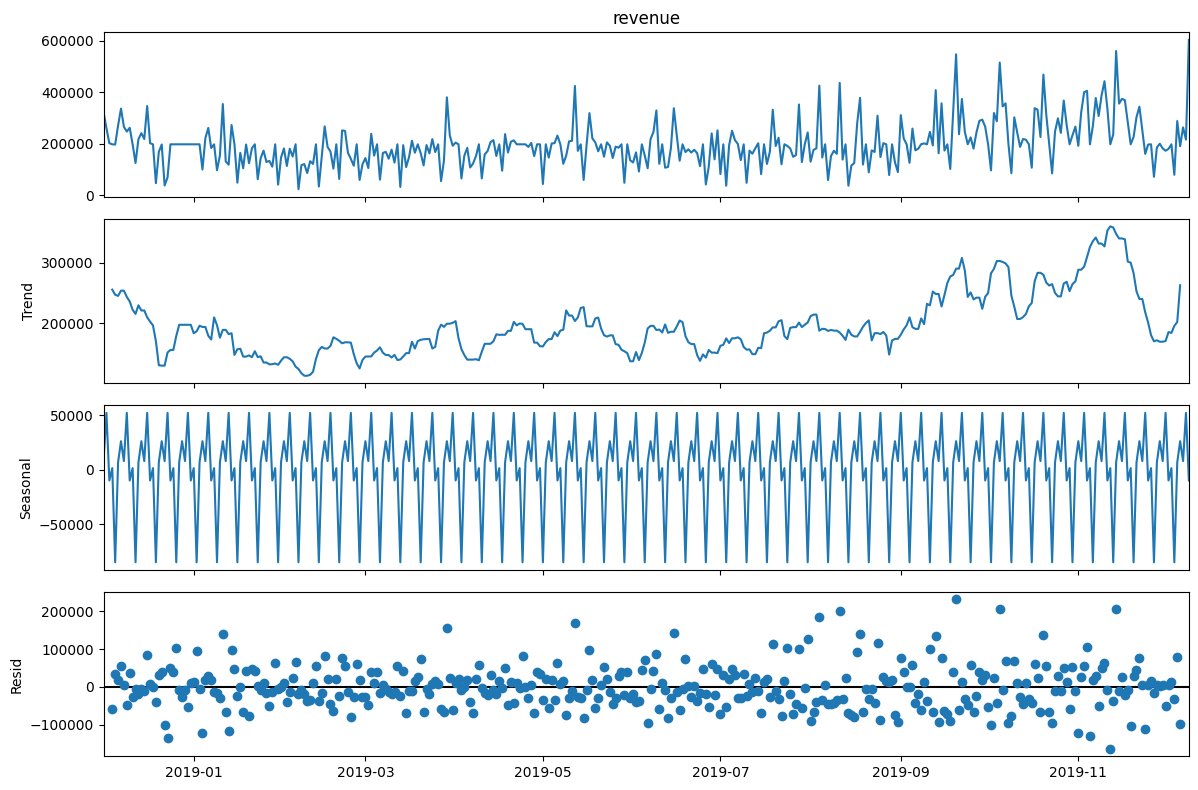

In [45]:
#show the result after using seasonal_decompose
plt.rcParams["figure.figsize"] = (12, 8)
decompose_result.plot()
plt.show()

From the resulting graph, it can be seen that there is no clear trend for the daily total revenue data. However, it is observed that in the long run, the data undergoes significant declines followed by a recovery period. In terms of seasonality, the data shows significant variation and difference in results in the cycle between days. Since the period is considered to be 7, it can be concluded that the total revenue is somewhat significantly affected by different days of the week.

#### Question 2.2

We will try to use time series model ARIMA for forecasting the future. you need to find the best model with different parameters on ARIMA model. The parameter range for p,d,q are all from [0, 1, 2]. In total, you need to find out the best model with lowest Mean Absolute Error from 27 choices based on the time from ”Jan-01-2019” to ”Nov-01-2019”

In [46]:
def model_evaluation(df, p=0, q=0, d=0, period_step = 1, start_date = None, max_date = None):
    start_date = df.index.min() if start_date is None else pd.to_datetime(start_date) #the first day of the data
    current_date = start_date
    max_date = df.index.max() if max_date is None else pd.to_datetime(max_date) #the last day of the data
    predictions = []
    #use a loop to evaluate the model, adding successive days to the training data.
    while current_date <= max_date:
        train_data = df[df.index < current_date] #get the training data
        max_forecast = len(df[(df.index >= current_date) & (df.index <= max_date)])
        model = ARIMA(train_data, order=(p, d, q)) #initialize the model
        try:
            result = model.fit().forecast(steps = min(period_step, max_forecast))
        except:
            #if any error is encountered, the prediction result is replaced by the average value of the training data.
            result = train_data.mean()
        predictions.append(result.values)
        current_date += pd.Timedelta(days = period_step)
    #transform predictions to 1-d numpy array
    predictions = np.concatenate(predictions, axis=0)
    groundtruth = df[(df.index >= start_date) & (df.index <= max_date)].values
    return mean_absolute_error(groundtruth, predictions) #calculate the mean absolute error

In [47]:
set_hyperparams = []
def create_hyperparams_set(list_hyperparams):
    if len(list_hyperparams) == 3:
       set_hyperparams.append(list_hyperparams)
       return
    for i in range(3):
        list_hyperparams.append(i)
        create_hyperparams_set(list_hyperparams.copy())
        list_hyperparams = list_hyperparams[:-1]

#create all the hyperparams set using backtracking to avoid having to use a large number of nested loops
create_hyperparams_set([])
set_hyperparams = np.array(set_hyperparams)

In [48]:
#The first 5 sets of numbers p, q, d
set_hyperparams[:5]

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 2],
       [0, 1, 0],
       [0, 1, 1]])

In [49]:
def hyperparams_evaluation(df, hyperparams, period_step = 1, start_date = '2019-01-01', max_date = '2019-11-01'):
    p, q, d = hyperparams
    mae_res = model_evaluation(df, p, q, d,  period_step, start_date, max_date)
    return mae_res

Test the model on each parameter set. In addition to evaluating the model's prediction on a new time step, evaluate the prediction on the next 7 time steps. Usually in practice, time-series models will predict for a long period in the future, for example, forecasting weather, temperature, and rainfall for the next week.

The evaluation results of each parameter set after completion will be saved into csv files and pushed to the team's github so that other members can easily track and reuse them because the evaluation time is quite long.

In [50]:
hyper_search = True
FILE_PATH = "mae_result_period_step_1.csv"
FILE_PATH_PERIOD_7 = "mae_result_period_step_7.csv"
#experiment with forecasting for just the next day and forecasting for the next 7 days
if hyper_search is False:
    #grid_search experiment
    list_mae_period_7 = []
    for hyperparams in set_hyperparams:
        mae_res = hyperparams_evaluation(filled_df, hyperparams, period_step = 7)
        list_mae_period_7.append(mae_res)
    list_mae = []
    for hyperparams in set_hyperparams:
        mae_res = hyperparams_evaluation(filled_df, hyperparams)
        list_mae.append(mae_res)
    #once the testing is complete, the results will be saved as a csv file and pushed to the team's shared github link.
    pd.DataFrame(data = {"p": set_hyperparams[:, 0], "q": set_hyperparams[:, 1],
                         "d": set_hyperparams[:, 2], "MAE": list_mae}).to_csv(FILE_PATH, index=False)
    pd.DataFrame(data = {"p": set_hyperparams[:, 0], "q": set_hyperparams[:, 1],
                         "d": set_hyperparams[:, 2], "MAE": list_mae_period_7}).to_csv(FILE_PATH_PERIOD_7, index=False)
    put_file_to_github(FILE_PATH, f"Data/{FILE_PATH}")
    put_file_to_github(FILE_PATH_PERIOD_7, f"Data/{FILE_PATH_PERIOD_7}")

In [51]:
#read the result file from github
df_mae_period_1 = pd.read_csv("https://raw.githubusercontent.com/khiempm209/Deakin-SIT742-Ass2/main/Data/mae_result_period_step_1.csv")
df_mae_period_7 = pd.read_csv("https://raw.githubusercontent.com/khiempm209/Deakin-SIT742-Ass2/main/Data/mae_result_period_step_7.csv")

In [52]:
#result of 1 time step prediction
df_mae_period_1.sort_values(by='MAE').head(5).reset_index(drop=True)

,p,q,d,MAE
0,0,1,1,54339.103161
1,1,1,1,54751.268672
2,0,2,1,54974.696991
3,1,1,0,55098.842137
4,1,2,1,55205.041725


In [53]:
#result of 7 time steps prediction
df_mae_period_7.sort_values(by='MAE').head(5).reset_index(drop=True)

,p,q,d,MAE
0,0,1,1,54702.914712
1,1,1,1,54880.302902
2,1,2,1,55037.584668
3,0,2,1,55043.723984
4,2,2,1,55087.642316


It can be seen that, with both types of experiments with different forecasting periods, the best set of numbers (p, q, d) obtained is (0, 1, 1). However, with the Arima model, when p = 0 means there is no AR component - autoregressive, meaning the current value does not depend on its previous values. At this point, the model becomes an MA (moving average) model. Therefore, the model becomes somewhat less reliable. In addition, the results of the hyperparameter set (1, 1, 1) are quite similar to the results of the set (0, 1, 1), so if used in practice, this hyperparameter set will have higher interpretability.

Besides using grid search to test model results on different sets of hyperparameters, there are other methods that use data visualization to somewhat determine the appropriate p, q, d coefficients.

For coefficient d, the right order of differencing is the minimum differencing required to get a near-stationary series that roams around a defined mean and the ACF plot reaches zero fairly quickly. Based on the MO5 module on Github Tuliblap of this subject, there is a simple trick mentioned: "If the autocorrelations are positive for any number of lags (10 or more), then the series needs further differentiation. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differentiated." Based on the results obtained in the charts below, it can be seen that a value of d equal to 1 is quite reasonable.

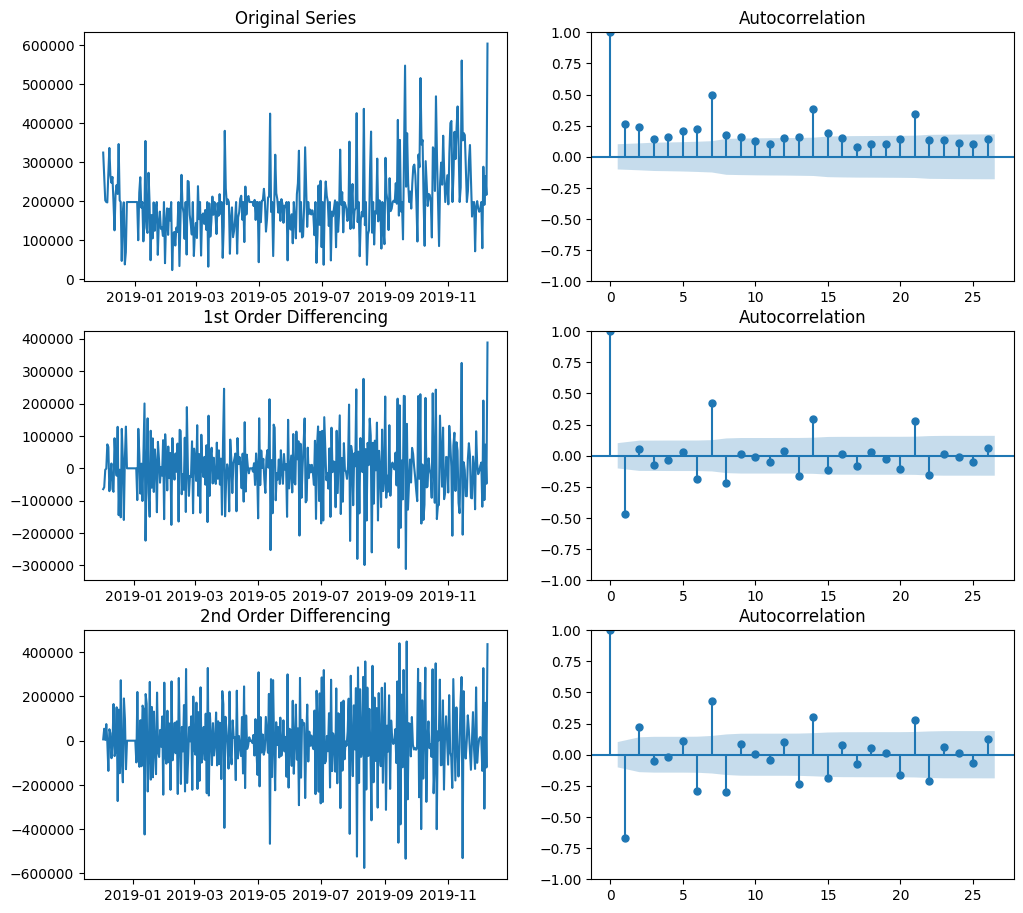

In [54]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(12, 11))
axes[0, 0].plot(filled_df.revenue); axes[0, 0].set_title('Original Series')
plot_acf(filled_df.revenue, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(filled_df.revenue.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(filled_df.revenue.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(filled_df.revenue.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(filled_df.revenue.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the p-factor, you can find a reasonable value by examining the Partial Autocorrelation Function (PACF) plot. Partial autocorrelation can be visualized as the correlation between a series and its lags, after subtracting the contributions from intermediate lags. So, PACF conveys the pure correlation between lags and the series. That way, it is possible to know whether that lag is necessary in the AR term or not. The order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot (M05). According to the results below, it can be seen that the p-value = 1 is very reasonable.

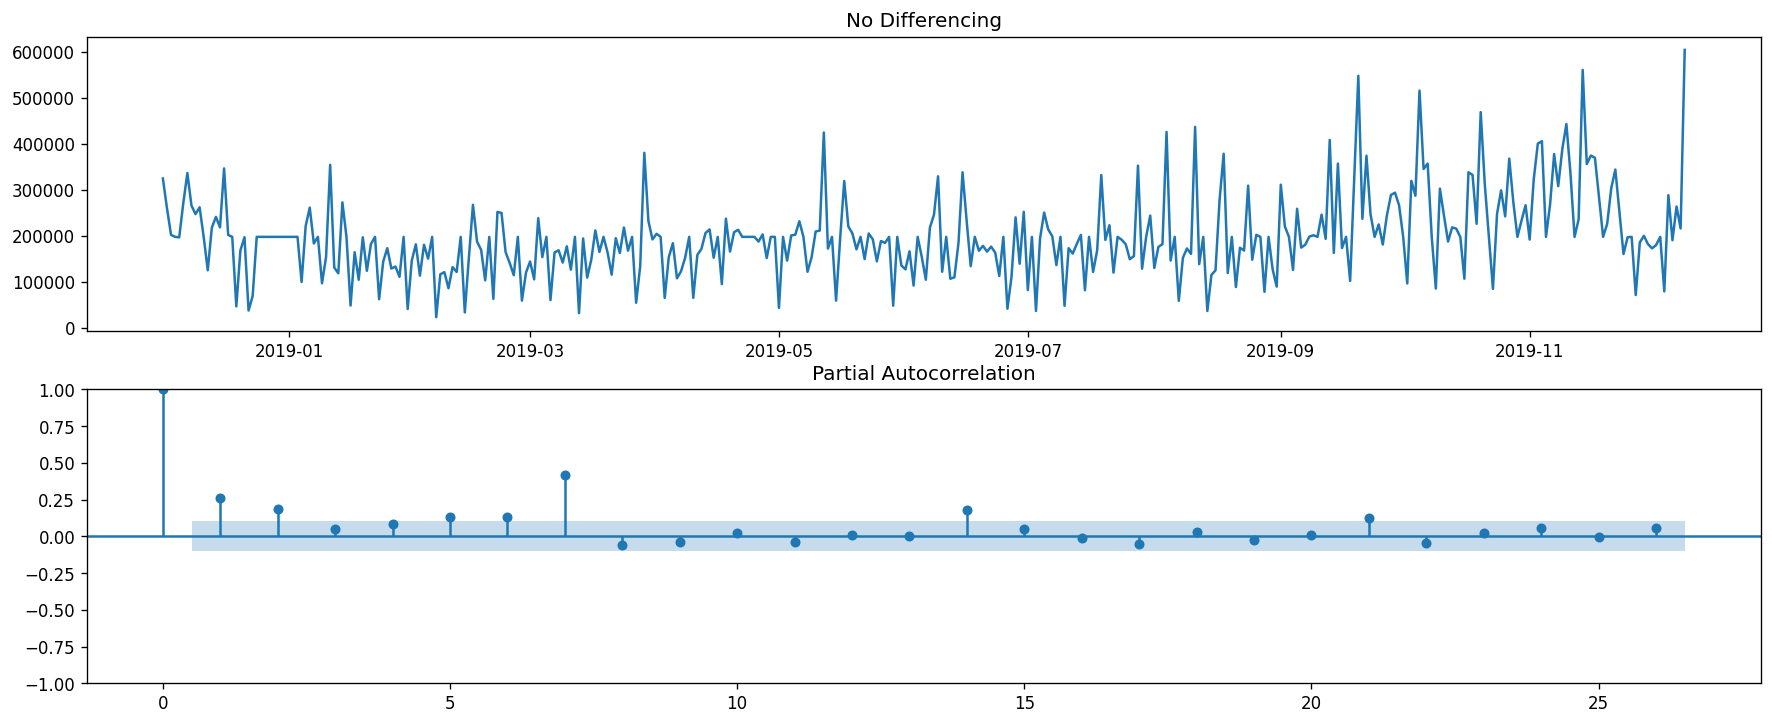

In [55]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(18, 7), 'figure.dpi':120})

fig, axes = plt.subplots(2, 1)
axes[0].plot(filled_df.revenue); axes[0].set_title('No Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(filled_df.revenue, ax=axes[1])

plt.show()

Besides evaluating the model's hyperparameters, the code below will visualize the actual data and the predicted data for the last 7 days of transaction data.

In [56]:
days_prediction = 7
train_data = filled_df[filled_df.index <= (filled_df.index.max() - pd.Timedelta(days = days_prediction))]['revenue']
model = ARIMA(train_data, order=(1, 1, 1)).fit()
results = model.forecast(steps=days_prediction)

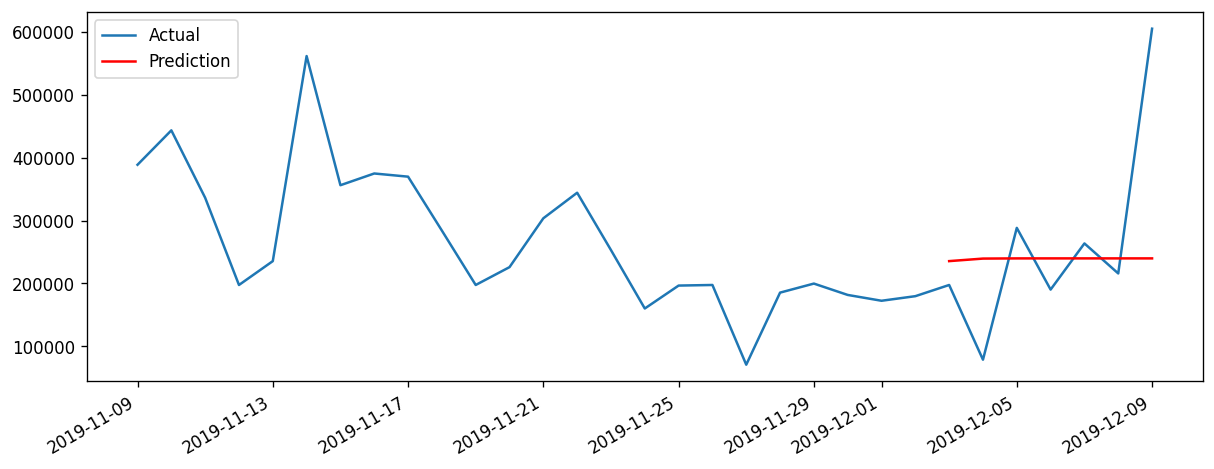

In [57]:
plt.rcParams.update({'figure.figsize':(12, 4), 'figure.dpi':120})
plot_data = filled_df[filled_df.index >= (filled_df.index.max() - pd.Timedelta(days = 30))]
plt.plot(plot_data.index, plot_data.values, label = 'Actual')
plt.plot(plot_data.tail(7).index, results, color = 'red', label = 'Prediction')
plt.xticks(rotation=30, ha='right')
plt.legend()
plt.show()

It can be seen that the prediction results of ARIMA are quite different from reality. In addition, ARIMA also tends to bring the prediction results closer to the average value of the data series. This is a weakness of ARIMA, so it is not reasonable to use this model to predict long-term time steps.

####Question 2.3

There are many deep learning time series forecasting methods, could you please explore those methods and write down the necessary data wrangling and modeling steps (steps on how to achieve, not actual code). Also please give the reference of the deep learning time series forecasting models you are using.

**1. Long-Short Term Memory**

Recurrent Neural Network or RNN (<a href='https://arxiv.org/abs/1912.05911'>Robin M. Schmidt</a>) is a very popular deep learning model architecture for sequential data such as text data or time-series data. The basic idea of ​​RNN is to store information about data in previous time steps through the use of a *hidden state*, thereby using them as a supplement to the data in the current time step to make predictions. The image below will briefly describe the architecture of RNN:

**Figure 1**: The basic architecture of RNN

<img src="https://d2l.ai/_images/rnn.svg">

Note: From *9.4. Recurrent Neural Networks*, by d2l.ai, 2021 (https://d2l.ai/chapter_recurrent-neural-networks/rnn.html)

Suppose we have the input data $X$, the hidden stata $H$ and a set of parameters for the model including: weight parameters for the input data $W_I$, weight parameters for the hidden state $W_H$, and weight parameters to predict the output $W_O$. Then, the hidden state at time $t$ will be: $H_t = \phi(X_t * W_I + H_{t - 1} * W_H)$ (ignore bias), where $\phi$ is the activation function, usually the tanh function in RNN. At this point, the output at time step t is: $O_t = H_t * W_O$. The model will optimize the parameters based on minimizing the loss function through back propagation process, in time-series problems, the loss function is used for continuous variables such as *mean square error*, *root mean square error*, etc.

Some strengths of RNN in time-series problems can be mentioned when compared with ARIMA as follows:

* **Nonlinear relationships**: while ARIMA mainly uses linear relationships from past data and residuals, RNN is able to leverage nonlinear activation functions (a characteristic of deep learning models), helping the model learn more complex patterns in the data.
* **Multivariate**: ARIMA can only use a single data variable related to the information of the time series itself to train the model and make predictions (univariate). Meanwhile, RNN can take advantage of other information besides the main data to make additional predictors. For example, to forecast the temperature for the next days, in addition to the temperature data of past days, the model can leverage related information such as humidity, wind volume in past days.

Despite its advantages over ARIMA, RNNs also have obvious and serious drawbacks, the most serious of which is the problem of *vanishing gradients*. It should be noted that RNNs use a single set of weight parameters for all time steps. This is an advantage as the model can scale well over long time series without increasing the number of trainable parameters. However, assuming a time step of t = 10, $H_t$ can be decomposed into:

$H_{10} = \phi(X_9 * W_I + H_{9} * W_H) = \phi(X_9 * W_I + \phi(X_8 * W_I + H_8 * W_H) * W_H)$

Continuing like this, until time steps 1 and 0, the amount of information they contribute to $H_{10}$ will be lost a lot due to having to go through too many activation functions and exponentials. Therefore, when performing backpropagation, these data parts will no longer be valuable for the model's parameter optimization. Therefore, in practice, RNN will not be suitable for training long time series when the output results will almost only depend on the most recent time steps.

Many approaches have been proposed to address this problem of RNNs. One of the earliest solutions is the Long Short-Term Memory or LSTM model architecture (<a href='https://www.researchgate.net/publication/13853244_Long_Short-term_Memory'>Sepp Hochreiter at el, 1997</a>). LSTM is a special variant of RNNs, designed to address the long-term dependency problem that RNNs face. It uses gates to control the flow of information in a data sequence. The gates include:
* **Forget Gate**: Decides what part of the information from the previous state will be forgotten.
* **Input Gate**: Decides what piece of new information will be added to the current state.
* **Output Gate**: Decides which part of the current state will be used as output.

Additionally, LSTM have a dedicated information pipeline called the *cell state* that runs through the entire sequence. These gates help add or remove information in the cell state in a controlled manner, allowing LSTMs to retain information for longer periods of time than conventional RNNs.


**Figure 2**: The basic architecture of LSTM

<img src="https://d2l.ai/_images/lstm-3.svg">

Note: From *10.1. Long Short-Term Memory (LSTM)*, by d2l.ai, 2021 (https://d2l.ai/chapter_recurrent-modern/lstm.html)

Thanks to the new architectures in the model, LSTM is superior to RNN in processing and storing information in a long data series, becoming a very popular method in language processing or time-series problems. Later, another variant of RNN was born, the Gated Recurrent Unit or GRU (<a href='https://arxiv.org/abs/1409.0473'>Bahdanau at el, 2015</a>). GRU is a more compact version of LSTM, often of comparable quality and significantly faster to compute.

LSTM can be implemented very simply through the Tensorflow or Pytorch libraries in Python. These libraries provide complete functions to build and train a complete LSTM model. There are a few things to note when preparing data for LSTM:
* First, because LSTM is a deep learning model, the parameters in the model will be very sensitive to input data with large data ranges. At this time, in the backpropagation process, the parameters are very easy to be over-adjusted, leading to the problem of gradient explosion. Therefore, the input data should be normalized to smaller ranges. Methods that can be used are Min-max normalization (bringing data to the range [0, 1]) or Standard Normalization (usually bringing data to the range [-3, 3] if there are not many outliers).
* Second, usually the input data will be in the form of a complete data series. If there are missing points, you can use a moving average to take the average value of the previous 2-3 days to fill. It is not recommended to use the average value of the entire data series or the future value for the date of data loss, because this will cause data leakage for the model.
* One thing that needs to be done is to set the length of the input data for the model. The reasonable number of data steps can be chosen from 6 to 10 steps, if the number of data steps is too long, even though using LSTM, the distant data parts will not have a big impact on the output results. The output of the model does not necessarily have to be just 1 time step, the time step can be set as the next 7 days (if the time steps are daily) or the next month depending on the requirements of the problem, of course, the more the number of outputs of the model increases, the lower the quality of the results will be. In addition, as mentioned above, LSTM can handle multivariate. At this point, the input data will be in the form of vectors (or lists, numpy arrays, tensor arrays in Python) with elements representing the input predictor variables.

In the model setup section, one of the things to pay attention to is setting the number of parameters for the model layers, through choosing the appropriate number of units for the dense layer. The number of units is small, the model will be too simple, the number of units is large, the model is likely to become complex, leading to overfitting. One method that can be used is to divide the data set into two parts, training and validation, then test different values ​​of hyperparameters such as units by training on the training set and then choosing the best value based on the evaluation results on the validation set.

In addition, it is possible to build a model architecture by stacking LSTM layers together. At this time, the input of hidden state t at the $i$ -th LSTM layer will be the output of hidden state t at the $i-1$-th th LSTM layer (when $i$ = 0 the input of hidden states is time series data). At the last LSTM layer, an additional *Attention* (<a href='https://arxiv.org/abs/1706.03762'>Ashish Vaswani at el, 2017</a>) layer can be used. Attention helps the model "pay attention" to the most important parts of the input, instead of processing all data equally. Finally, additional hidden state layers can be installed at the top layer of the model. Other settings that need attention in model building include adding Dropout, Batchnorm layers or using the L2 regularization method to make the model more general without depending too much on the training set.

When building a model in a time-series problem when the output is a continuous variable, apply loss functions such as root mean square error, mean square error to optimize the model. During training, it is required to install additional hyperparameters such as learning rate or batch size. Typically, deep learning models use a small learning rate (around 0.005 or 0.001) to ensure a smoother training process. Batch sizes are often set to integers that are powers of 2 (such as 128, 512) to accommodate hardware computation. The larger the batch size, the faster the computation (due to the ability to compute in parallel on each sample when applying GPUs) and the model parameter optimization becomes more reliable when performed on a full amount of data. However, this will require a large amount of resources, especially VRAM in the GPU. In contrast, with a small batch size, the amount of resources required is less but the computation process takes longer. Hyperparameters also somewhat affect the results of the model, so it is also possible to use hyperparameter search methods such as Random Search or Bayes Optimization similar to other settings directly in the model.

In the code below, a small implementation of preparing the data, setting up the model and training the LSTM on the transaction dataset in part 2 of the assignment. The results will not be able to evaluate the robustness of the model because the number of samples in the data is quite small, not suitable for the needs of deep learning models.

In [93]:
#choose the number of input time steps and output time steps by using n_in and n_out
def create_train_data(data, n_in=7, n_out=1):
    train_data, label_data = [], []
    i, len_data = 0, len(data)
    while i + (n_in + n_out) <= len(data):
        train_data.append(data[i: i + n_in])
        label_data.append(np.concatenate(data[i + n_in: i + (n_in + n_out)], axis = 0))
        i += 1
    return np.array(train_data), np.array(label_data)

In [94]:
data_lstm = filled_df[filled_df.index <= pd.to_datetime('2019-12-02')][['revenue']]
#using standard scaler to normalize the data before being used as input to the model
std_scaler = StandardScaler().fit(data_lstm)
data_lstm = std_scaler.transform(data_lstm)
train_data, label_data = create_train_data(data_lstm)

In [95]:
#create the test data part
test_data = filled_df[(filled_df.index > (pd.to_datetime('2019-12-02') - pd.Timedelta(days = 7))) &
                      (filled_df.index <= pd.to_datetime('2019-12-02'))][['revenue']]
test_data = std_scaler.transform(test_data[['revenue']])

In [90]:
#initialize the model with two LSTM stacks with pre-defined the number of units per layer
#use Dropout layer for model regularization
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(train_data.shape[1], train_data.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
#the number of unit in last dense layer equals to the number of desired output time steps
model.add(Dense(1))
#use the mean squared error as the loss function, and Adam as the optimization method with a learning rate of 0.001
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=0.001))

In [91]:
#set the number of epochs during training to 20 and use batch size to 16
model.fit(train_data, label_data, epochs=20, batch_size=16, verbose=1, shuffle=False)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6784
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6556
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6553
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6400
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6365
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6541
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6672
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6679
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6205
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6549
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6358
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6408
Epoch 13/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6717
Epoch 14/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6519
Epoch 15/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6469
Epoch 16/20
23/23 ━

In [96]:
#reshape the test data (because the test data has only one sample)
test_data = test_data.reshape(1, test_data.shape[0], test_data.shape[1])
test_data.shape

(1, 7, 1)

In [98]:
red = model.pred(test_data)
#inverse transform the prediction to the original form
std_scaler.inverse_transform(pred)

array([[162007.75]], dtype=float32)

**2. N-BEATS**

N-BEATS, Neural Basis Expansion Analysis for Time Series Forecasting (<a href='https://arxiv.org/abs/1905.10437'>Boris N. Oreshkin, 2019</a>) is a deep learning model designed for time series forecasting. This model was introduced to improve the accuracy and explainability of traditional forecasting methods. The basic architecture of N-Beats is shown in the image below:

**Figure 3**: The basic architecture of N-BEATS (<a href='https://arxiv.org/abs/1905.10437'>Boris N. Oreshkin, 2019</a>)

<img src="https://miro.medium.com/v2/resize:fit:1400/1*wgLibCLYo7cSyO6moaK2Hg.png" height = 400 width = 600>

Essentially, N-BEATS is a model consisting of several sequentially connected *blocks*. Each block consists of two main parts: **backcast** and **forecast**. The $l$-th block takes an input data sequence $x_l$ and produces two outputs $\hat{x_l}$ and $\hat{y}_l$, respectively, where $\hat{y}_l$ is the forward forecast, and $\hat{x_l}$ is the model's best estimation of the input data $x_l$, also known as the backcast. Assuming the model output has length $H$ ($\hat{y}$ has length $H$), then the typical lengths of $x_l$ are usually set between $2H$ and $7H$. Each block is initialized with fully-connected layers (in this case 4 layers) to produce the forward $\theta^{f}_{l}$ and the backward $\theta^{b}_{l}$ predictors of expansion coefficients. The general formula is as follows:

$h_{l,1} = FC_{l, 1}(x_l), h_{l, 2} = FC_{l, 2}(h_{l, 1}), h_{l, 3} = FC_{l, 3}(h_{l, 2}), h_{l, 4} = FC_{l, 4}(h_{l, 3})$

$\theta^{f}_{l} = W^{f}_{l} * h_{l, 4},\space \theta^{b}_{l} = W^{b}_{l} * h_{l, 4}$

In which, the $FC$ layers have the formula: $h_{l,i} = \phi(W_{l, i} * (h_{l, i- 1}))$ with $\phi$ is the activation function, usually be *Relu*. Next, the expansion coefficients $\theta^{f}_{l}$ and $\theta^{b}_{l}$ will be mapped to output through the basic layers, $g^f_l$ and $g^b_l$: $\hat{y}_l = g^f_l(\theta^{f}_{l}),\space \hat{x}_l = g^b_l(\theta^{b}_{l})$. The function of $g^f_l$ and $g^b_l$ is to provide sufficiently rich sets $|{v^f_i}|^{dim(θ^f_l)}_{i=1}$ and $|{v^b_i}|^{dim(θ^b_l)}_{i=1}$such that their respective outputs can be represented adequately via varying expansion coefficients $\theta^f_l$ and $\theta^b_l$.  $g^f_l$ and $g^b_l$ can either be chosen to be learnable or can be set to specific functional forms to reflect certain problem-specific inductive biases in order to appropriately constrain the structure of outputs. The task of each block is to predict the forward expansion coefficients $θ^f_l$ with the ultimate goal of optimizing the accuracy of the partial forecast $\hat{y}_l$ by properly mixing the basis vectors supplied by $g^f_l$. Additionally, this sub-network predicts backward expansion coefficients $\theta^b_l$ used by $g^b_l$ to produce an estimate of $x_l$ with the ultimate goal of helping the downstream blocks by removing components of their input that are not helpful for forecasting.

For the first block, its input $x_l$ is the input input $x$ of model. For all remaining blocks, their inputs $x_l$ are residual outputs of the previous blocks: $x_l = x_{l - 1} - \hat{x}_{l-1}$. According to the authors, the previous block removes the portion of the signal $\hat{x}_{l-1}$ that it can approximate well, making the forecast job of the downstream blocks easier. Additionally, each block outputs a partial forecast $\hat{y}_{l}$  that is first aggregated at the stack level and then at the overall network level, providing a hierarchical decomposition. The final forecast $\hat{y}$ is the sum of all partial forecasts.

Another important point in N-BEATS is that it has two configurations in the architecture, based on the selection of $g^b_l$ and $g^f_l$. They are **generic architecture** and **interpretable architecture** respectively. Specifically, their definitions and differences are as follows:
* **Generic Architecture**: This architecture of N-BEATS is designed to maximize predictive accuracy without focusing on model explainability. Since it does not rely on any assumptions about the time series,  $g^b_l$ and $g^f_l$ are simply set to be a linear projection of the previous layer output. This makes the Generic architecture very flexible and applicable to many different data types.
* **Interpretable Architecture**: This overall architecture consists of two stacks: the *trend stack* is followed by the *seasonality stack* (note that for the generic model the notion of stack was not necessary). In trend stacks, the authors propose to constrain $g^b_l$ and $g^f_l$, to be a polynomial of small degree p, a function slowly varying across forecast window to mimic the behavior that most of the time it is a monotonic function, or at least a slowly varying function. For seasonality stack, a typical characteristic of seasonality is that it is a regular, cyclical, recurring fluctuation. Therefore, the authors propose to constrain $g^b_l$ and $g^f_l$, to belong to the class of periodic functions, like the Fourier series. It can be seen that using stacks with distinct features in a time series in this architecture is quite similar to the way it works in the seasonal_decompose function in the above task.

The choice of architecture to solve the problem depends on the type of input data. When the data has trend and seasonality characteristics, the interpretable architecture is the ideal choice because it takes advantage of this structure to make more accurate and understandable forecasts. When there are no assumptions about the time series nature, the generic architecture is a reasonable choice.

For N-BEATS, setting up the input data for the model, building the model and the way to set up during training is almost similar to LSTM as presented above because the nature of these two model architectures are both deep learning models and are used on sequence data. More specifically, in N-BEATS, it is necessary to determine the number of blocks and the number of stacks to use. These are the two most important hyperparameters of the model, because as the number of blocks and stacks increases, the ability of the model to learn complex features of the data also increases, but it is necessary to pay attention to the occurrence of overfitting. Typically, an N-BEATS model will have 2 to 3 stacks and each stack will contain about 3 to 6 blocks. In addition, as presented above, there are 2 options for building blocks of the model: generic block and interpretable block. Choosing the appropriate block type will be based on the process of surveying and analyzing the input data, to see if there are any prominent characteristics of trends or seasonality.



### Part 3. Discussion

**a. How you and your team member collaborate on this assignment?**

We use Teams to exchange ideas and solve problems encountered while completing the assignment. In addition to having regular meetings, we also use the messaging feature to remind each other and discuss solutions. If one member can't attend a meeting, we prepare a discussion summary for them to read, which helps them catch up on the work.

We also use GitHub for file sharing. One member set up a GitHub repository where everyone can upload their work. This allows us to cross-check and compare our work on the same questions. It's also useful for consolidating different parts of the work into one file. Additionally, we can always trace back to previous versions if needed. For members who perform similar tasks, each person will have a separate branch on their github link next to the main branch. Members will take turns uploading and updating their solutions during the implementation process whenever there is a new update. Then one member will be responsible for checking for conflicts if any and merging the code into the main branch (storing the main solution of the whole team). Experimental results and data output files will also be saved to github to ensure that all members can follow even if that part is not part of their task. We use Google Colab as a platform to perform the task. Google Colab provides very intuitive features that help users easily upload code to github (can choose branches as desired and write comments). In addition, in the case of uploading files to github, it is necessary to provide personal information such as tokens, Google Colab provides the 'Secrets' feature to store confidential information and easily customize for each person.

**b. What you have learned with your team member from the second assignment.**

In the second assignment, in part 1, we learned how to use PySpark and Pandas for data wrangling and how to transform data to generate meaningful insights for analysis. In part 2, we learned how to process time series data, how to apply ARIMA model and set its hyperparameters for training and prediction. We also had the opportunity to research and learn about deep learning models to solve these problems.

Additionally, we learned how to collaborate effectively to solve various questions. We also learned how to organize productive meetings to discuss any problems we encountered, and we became familiar with using GitHub for file sharing.

**c. What is the contribution of each the team member for finishing the second assignment.**

To complete the assignment, the three of us helped each other by discussing tasks together and taking responsibility for different parts.

Minn contributed by answering and recording all the answers for Part 2, setting up the GitHub repository, and consolidating the IPython notebook file.

Thenuka and Jeff both contributed to the answers for Part 1. Thenuka primarily focused on recording the audio for questions 1.1 to 1.5 and also helped with suggestions for formatting the markdown. Jeff mainly worked on recording the audio for questions 1.6 to 1.10. Additionally, he assisted with administrative tasks, such as organizing meetings and taking meeting notes.